# Modelling

# Prophet Model Development

FBProphet uses a combination of regression models and Bayesian inference to model time series data. it allows the flexibility to model complicated time series features by fitting trends and multiple seasonalities to incorporate yearly, monthly, weekly and daily pattens along with holiday effects.

FBProphet also allows for the inclusion of additional regressors in the model. Regressors are external variables that may influence the time series, such as holidays, weather patterns, or marketing campaigns. Including regressors in the model can improve the accuracy of the forecasts by capturing the effects of these external variables on the time series.

In [2]:
# import required libraries
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Import the clean Merged Dataset (Natural Gas demand and Weather factors)
This dataset is the historical daily natural gas demand in energy unit (TJ/d) and the weather data in Saskatchewan from November 1, 2013 to October 31, 2023.

In [3]:
# Import the merged dataset (Natural Gas demand and Weather factors)
merged_df = pd.read_csv('../data/merged_data.csv')
merged_df.head()

,DATE,NG_DEMAND,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2013-11-01,617,44.400000,80.333333,14.833333,0.0,0.140000,-2.933333,3.166667,9.206667,28.066667,40.600000
1,2013-11-02,630,34.133333,73.066667,16.293333,0.0,0.226667,-5.866667,1.706667,9.266667,8.400000,25.400000
2,2013-11-03,688,60.133333,81.600000,16.726667,0.0,5.806667,-2.166667,1.273333,4.706667,24.400000,55.000000
3,2013-11-04,815,66.466667,79.133333,23.540000,0.0,0.900000,-9.106667,-5.540000,-1.906667,31.466667,56.933333
4,2013-11-05,789,53.000000,71.666667,27.820000,0.0,0.040000,-14.966667,-9.820000,-4.633333,15.800000,21.600000


## Step 2 : Data Preparation for Modelling 
For this step, we are preparing the series Cross-validation evaluation method

In [4]:
# Prepare this dataset for cross-validation prophet modelling 
merged_df_mod = merged_df.copy()
merged_df_mod.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'}, inplace=True)

In [5]:
# Split the data into training set from 2013-11-01 to 2021-10-31, and using 2021-11-01 to 2023-10-31 as test/validation set
train_df = merged_df[merged_df['DATE'] < '2021-12-01']
validation_df = merged_df[merged_df['DATE'] >= '2021-12-01']

# Print the shape of the train-test split
print(train_df.shape)
print(validation_df.shape)

(2952, 12)
(700, 12)


## Step 3: Model Development
In this step, the model development include a base Prophet model using the train-test split method and cross-validation. Then the better performed model is further turnd to refined the model performance.

### 1. Prophet Base Model 
**Creating and Forecasting with Prophet**

In [6]:
# Let's do the transformation required for using fbProphet in the train dataset: columns ds (Date) and y (value)
train_df1 = train_df.copy()
train_df1.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'}, inplace=True)

# Let's do the transformation required for using fbProphet in validation dataset: columns ds (Date) and y (value)
test_df1 = validation_df.copy()
test_df1.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'}, inplace=True)

00:22:44 - cmdstanpy - INFO - Chain [1] start processing
00:22:47 - cmdstanpy - INFO - Chain [1] done processing


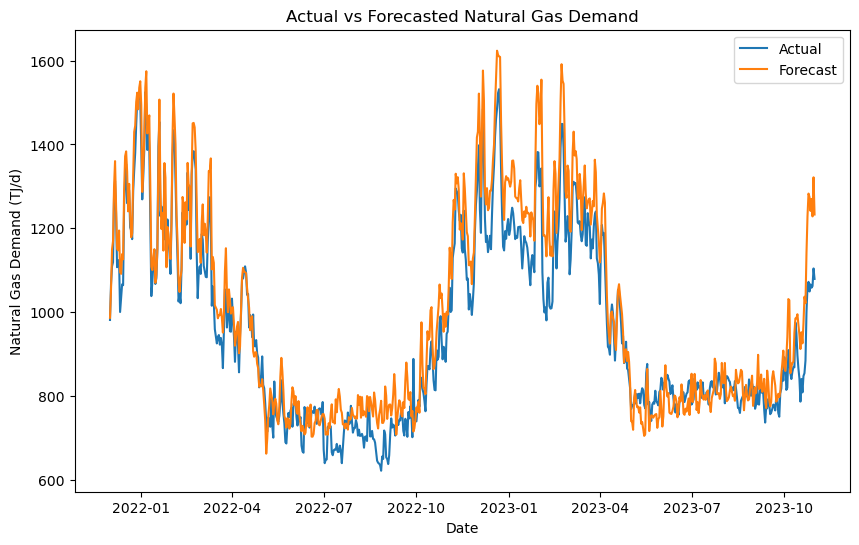

In [7]:
# Importing the necessary libraries and modules
from sklearn.base import BaseEstimator, RegressorMixin
from prophet import Prophet
import matplotlib.pyplot as plt

# Defining a wrapper class for the Prophet model
class ProphetWrapper(BaseEstimator, RegressorMixin):
    # Initializing the class with default parameters
    def __init__(self, interval_width=0.9, yearly_seasonality=True, seasonality_mode='multiplicative'):
        self.interval_width = interval_width
        self.yearly_seasonality = yearly_seasonality
        self.seasonality_mode = seasonality_mode
        self.model = None

    # Defining the fit method to train the model
    def fit(self, X, y=None):
        # Creating a Prophet model with the given parameters
        self.model = Prophet(interval_width=self.interval_width, yearly_seasonality=self.yearly_seasonality, seasonality_mode=self.seasonality_mode)
        
        # Adding additional regressors to the model
        for regressor in ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
                          'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']:
            self.model.add_regressor(regressor)

        # Fitting the model to the data
        self.model.fit(X)

        return self

    # Defining the predict method to generate predictions
    def predict(self, X):
        return self.model.predict(X)

# Instantiating the ProphetWrapper class
model = ProphetWrapper()

# Fitting the model to the training data
model.fit(train_df1)

# Generating predictions on the test data
forecast1 = model.predict(test_df1)

# Convert 'ds' to datetime
test_df1['ds'] = pd.to_datetime(test_df1['ds'])
forecast1['ds'] = pd.to_datetime(forecast1['ds'])

# Plot the actual and forecasted 'NG_DEMAND'
plt.figure(figsize=(10, 6))
plt.plot(test_df1['ds'], test_df1['y'], label='Actual')
plt.plot(forecast1['ds'], forecast1['yhat'], label='Forecast')
plt.title('Actual vs Forecasted Natural Gas Demand')
plt.xlabel('Date')
plt.ylabel('Natural Gas Demand (TJ/d)')
plt.legend()
plt.show()

**Performance Metrics**

In [26]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming y_true is the actual values and y_pred is the predicted values
y_true = test_df1['y']
y_pred = forecast1['yhat']

mse = mean_squared_error(y_true, y_pred)     # Calculate Mean Squared Error (MSE)
rmse = np.sqrt(mse)     # Calculate Root Mean Squared Error (RMSE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100     # Calculate Mean Absolute Percentage Error (MAPE)
mae = mean_absolute_error(y_true, y_pred)     # Calculate Mean Absolute Error (MAE)
mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100       # Calculate Median Absolute Percentage Error (MDAPE)
r2 = r2_score(y_true, y_pred)     # Calculate R squared

# Print the performance metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")
print(f"MDAPE: {mdape}%")
print(f"R squared: {r2}")

MSE: 5597.74485265844
RMSE: 74.8180783812204
MAPE: nan%
MAE: 59.916125022741866
MDAPE: nan%
R squared: 0.8844150706751865


### 2. Prophet with Cross-Validation
- This dataset has 10 years (3651 days) of daily sales data. The initial parameter is set to ‘1095 days’, which means the initial training period consists of the first three years of data.
- The period parameter is set to ‘275 days’, which indicates that the cross-validation will be performed every 275 days (approximately every 9 months). The horizon parameter is set to ‘275 days’, meaning that each cross-validation step will generate forecasts for the next 275 days (9 months).

**Building the Model**

In [10]:
# Importing the necessary libraries and modules
from prophet import Prophet
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from prophet.diagnostics import cross_validation, performance_metrics

In [107]:
# Define a wrapper for the Prophet model to use with sklearn
class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, interval_width=0.9, yearly_seasonality=True, seasonality_mode='additive'):
        self.interval_width = interval_width
        self.yearly_seasonality = yearly_seasonality
        self.seasonality_mode = seasonality_mode
        self.model = None

    def fit(self, X, y=None):
        self.model = Prophet(interval_width=self.interval_width, yearly_seasonality=self.yearly_seasonality, seasonality_mode=self.seasonality_mode)
        
        # Add additional regressors
        for regressor in ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
                          'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']:
            self.model.add_regressor(regressor)

        self.model.fit(X)

        return self

    def predict(self, X):
        return self.model.predict(X)

# Instantiate and fit the model
model = ProphetWrapper()
model.fit(merged_df_mod)

# Perform cross-validation
df_cv = cross_validation(model.model, initial='1825 days', period='456 days', horizon='456 days')

# Calculate performance metrics
df_metrics = performance_metrics(df_cv)

00:18:23 - cmdstanpy - INFO - Chain [1] start processing
00:18:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

00:18:28 - cmdstanpy - INFO - Chain [1] start processing
00:18:29 - cmdstanpy - INFO - Chain [1] done processing
00:18:30 - cmdstanpy - INFO - Chain [1] start processing
00:18:32 - cmdstanpy - INFO - Chain [1] done processing
00:18:33 - cmdstanpy - INFO - Chain [1] start processing
00:18:35 - cmdstanpy - INFO - Chain [1] done processing
00:18:36 - cmdstanpy - INFO - Chain [1] start processing
00:18:39 - cmdstanpy - INFO - Chain [1] done processing


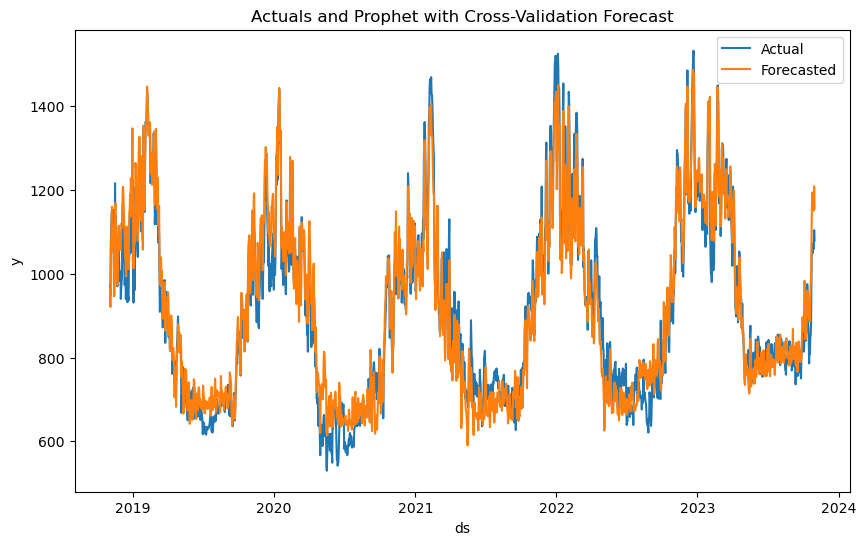

In [108]:
# Plotting actuals and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_cv['ds'], df_cv['y'], label='Actual')
plt.plot(df_cv['ds'], df_cv['yhat'], label='Forecasted')
plt.legend()
plt.xlabel('ds')
plt.ylabel('y')
plt.title('Actuals and Prophet with Cross-Validation Forecast')
plt.show()

**Performance Metrics**

In [109]:
# Calculate MAE, MSE, and RMSE
mae_cv = mean_absolute_error(df_cv['y'], df_cv['yhat'])
mse_cv = mean_squared_error(df_cv['y'], df_cv['yhat'])
rmse_cv = np.sqrt(mse_cv)
r2_cv = r2_score(df_cv['y'], df_cv['yhat'])
mape_cv = np.mean(np.abs((df_cv['y'] - df_cv['yhat']) / df_cv['y'])) * 100
mdape_cv = np.median(np.abs((df_cv['y'] - df_cv['yhat']) / df_cv['y'])) * 100

print(f'Mean Absolute Error: {mae_cv:.2f}')
print(f'Mean Squared Error: {mse_cv:.2f}')
print(f'Root Mean Squared Error: {rmse_cv:.2f}')
print(f'R-squared: {r2_cv:.2f}')
print(f'Mean Absolute Percentage Error: {mape_cv:.2f}%')
print(f'Median Absolute Percentage Error: {mdape_cv:.2f}%')

Mean Absolute Error: 43.30
Mean Squared Error: 2920.11
Root Mean Squared Error: 54.04
R-squared: 0.94
Mean Absolute Percentage Error: 5.07%
Median Absolute Percentage Error: 4.12%


#### Checking for Overfitting
To monitor the performance of the model on the cross-validation method when the model is being trained to check for signs of overfitting, we can modify the code to include a validation set during the training process. However, the Prophet model does not directly support validation during training.

A common practice to monitor overfitting during training in time series forecasting is to plot the forecast errors (like RMSE or MAE) for both the training set and a validation set for each cross-validation fold. If the error on the validation set starts to increase while the error on the training set continues to decrease, it’s a sign of overfitting.

  0%|          | 0/4 [00:00<?, ?it/s]

12:57:32 - cmdstanpy - INFO - Chain [1] start processing
12:57:33 - cmdstanpy - INFO - Chain [1] done processing
12:57:34 - cmdstanpy - INFO - Chain [1] start processing
12:57:36 - cmdstanpy - INFO - Chain [1] done processing
12:57:37 - cmdstanpy - INFO - Chain [1] start processing
12:57:39 - cmdstanpy - INFO - Chain [1] done processing
12:57:40 - cmdstanpy - INFO - Chain [1] start processing
12:57:43 - cmdstanpy - INFO - Chain [1] done processing


Fold 2018-11-02 00:00:00
Mean Absolute Error: 41.37
Mean Squared Error: 2749.52
Root Mean Squared Error: 52.44
R-squared: 0.94
Mean Absolute Percentage Error: 4.66%
Median Absolute Percentage Error: 3.77%
--------------------------------------------------
Fold 2020-02-01 00:00:00
Mean Absolute Error: 44.02
Mean Squared Error: 3108.61
Root Mean Squared Error: 55.75
R-squared: 0.93
Mean Absolute Percentage Error: 5.59%
Median Absolute Percentage Error: 4.13%
--------------------------------------------------
Fold 2021-05-02 00:00:00
Mean Absolute Error: 47.36
Mean Squared Error: 3178.74
Root Mean Squared Error: 56.38
R-squared: 0.93
Mean Absolute Percentage Error: 5.45%
Median Absolute Percentage Error: 4.96%
--------------------------------------------------
Fold 2022-08-01 00:00:00
Mean Absolute Error: 39.92
Mean Squared Error: 2555.31
Root Mean Squared Error: 50.55
R-squared: 0.94
Mean Absolute Percentage Error: 4.54%
Median Absolute Percentage Error: 3.29%
---------------------------

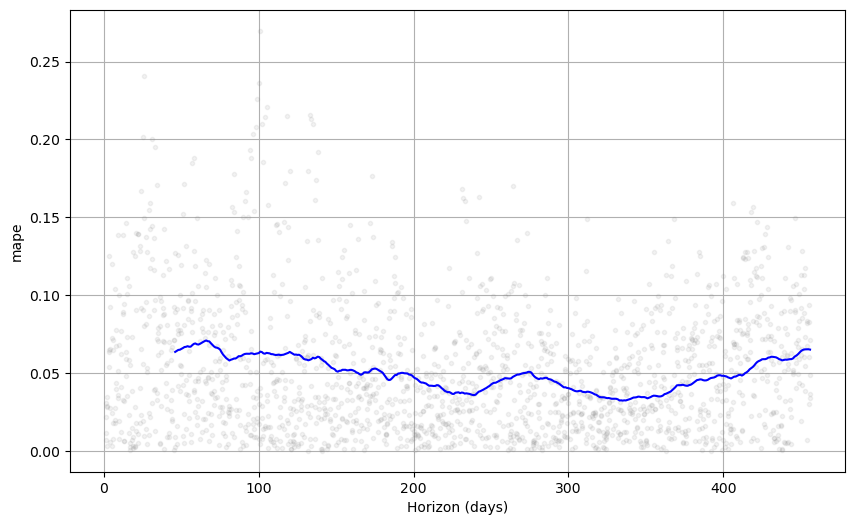

In [88]:
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

# Perform cross-validation with the best model
df_cv_ch = cross_validation(random_search.best_estimator_.model, initial='1825 days', period='456 days', horizon='456 days')

# Calculate performance metrics for each fold
df_metrics_ch = performance_metrics(df_cv_ch)

# Calculate MAE, MSE, RMSE, and R-squared for each fold
for fold, df_fold in df_cv_ch.groupby('cutoff'):
    mae_ch = mean_absolute_error(df_fold['y'], df_fold['yhat'])
    mse_ch = mean_squared_error(df_fold['y'], df_fold['yhat'])
    rmse_ch = np.sqrt(mse_ch)
    r2_ch = r2_score(df_fold['y'], df_fold['yhat'])
    mape_ch = np.mean(np.abs((df_fold['y'] - df_fold['yhat']) / df_fold['y'])) * 100
    mdape_ch = np.median(np.abs((df_fold['y'] - df_fold['yhat']) / df_fold['y'])) * 100

    print(f'Fold {fold}')
    print(f'Mean Absolute Error: {mae_ch:.2f}')
    print(f'Mean Squared Error: {mse_ch:.2f}')
    print(f'Root Mean Squared Error: {rmse_ch:.2f}')
    print(f'R-squared: {r2_ch:.2f}')
    print(f'Mean Absolute Percentage Error: {mape_ch:.2f}%')
    print(f'Median Absolute Percentage Error: {mdape_ch:.2f}%')
    print('-'*50)  # This will print a line after each fold

# Plotting RMSE
fig = plot_cross_validation_metric(df_cv_ch, metric='mape')
plt.show()


- The model’s performance varied across the four folds. In the 2018 fold, the model had a Mean Absolute Error (MAE) of 41.37 and an R-squared value of 0.94. In the 2020 fold, the MAE increased slightly to 44.02, and the R-squared value decreased to 0.93.
- The MAE further increased to 47.36 in the 2021 fold, with the R-squared value remaining at 0.93. However, in the 2022 fold, the MAE decreased to 39.92, and the R-squared value increased to 0.94.
- The Mean Absolute Percentage Error (MAPE) and Median Absolute Percentage Error (MdAPE) also varied across the folds, ranging from 4.54% to 5.59% and 3.29% to 4.96%, respectively.
- Overall, the model showed an improving trend in the initial folds but demonstrated variability in its performance in the later folds..

#### Option 2 Cross-validaion
Initial = 1460, period = 365, and horizon = 365

12:59:03 - cmdstanpy - INFO - Chain [1] start processing
12:59:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:59:08 - cmdstanpy - INFO - Chain [1] start processing
12:59:09 - cmdstanpy - INFO - Chain [1] done processing
12:59:10 - cmdstanpy - INFO - Chain [1] start processing
12:59:12 - cmdstanpy - INFO - Chain [1] done processing
12:59:13 - cmdstanpy - INFO - Chain [1] start processing
12:59:15 - cmdstanpy - INFO - Chain [1] done processing
12:59:16 - cmdstanpy - INFO - Chain [1] start processing
12:59:18 - cmdstanpy - INFO - Chain [1] done processing


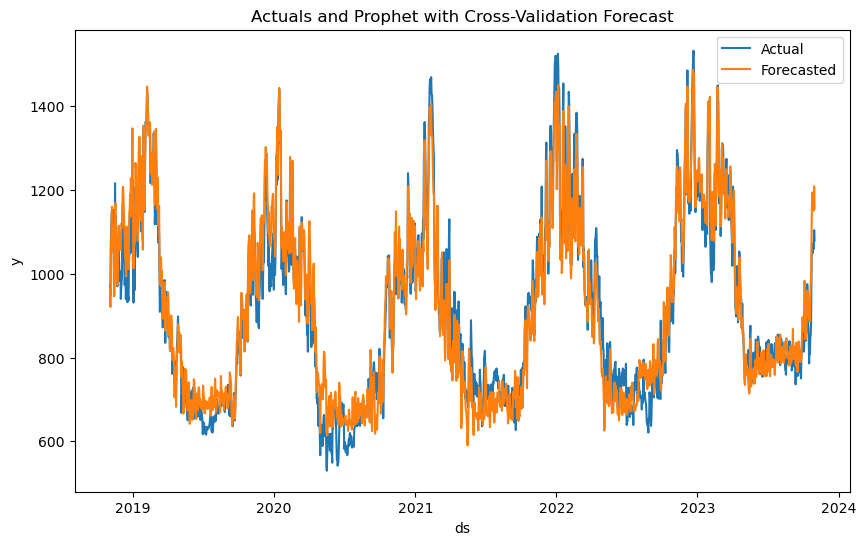

Mean Absolute Error: 43.30
Mean Squared Error: 2920.11
Root Mean Squared Error: 54.04
R-squared: 0.94
Mean Absolute Percentage Error: 5.07%
Median Absolute Percentage Error: 4.12%


In [89]:
# Define a wrapper for the Prophet model to use with sklearn
class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, interval_width=0.9, yearly_seasonality=True, seasonality_mode='additive'):
        self.interval_width = interval_width
        self.yearly_seasonality = yearly_seasonality
        self.seasonality_mode = seasonality_mode
        self.model = None

    def fit(self, X, y=None):
        self.model = Prophet(interval_width=self.interval_width, yearly_seasonality=self.yearly_seasonality, seasonality_mode=self.seasonality_mode)
        
        # Add additional regressors
        for regressor in ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
                          'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']:
            self.model.add_regressor(regressor)

        self.model.fit(X)

        return self

    def predict(self, X):
        return self.model.predict(X)

# Instantiate and fit the model
model = ProphetWrapper()
model.fit(merged_df_mod)

# Perform cross-validation
df_cv4 = cross_validation(model.model, initial='1825 days', period='456 days', horizon='456 days')

# Calculate performance metrics
df_metrics4 = performance_metrics(df_cv4)

# Plotting actuals and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_cv4['ds'], df_cv4['y'], label='Actual')
plt.plot(df_cv4['ds'], df_cv4['yhat'], label='Forecasted')
plt.legend()
plt.xlabel('ds')
plt.ylabel('y')
plt.title('Actuals and Prophet with Cross-Validation Forecast')
plt.show()

# Calculate MAE, MSE, and RMSE
mae_cv4 = mean_absolute_error(df_cv4['y'], df_cv4['yhat'])
mse_cv4 = mean_squared_error(df_cv4['y'], df_cv4['yhat'])
rmse_cv4 = np.sqrt(mse_cv4)
r2_cv4 = r2_score(df_cv4['y'], df_cv4['yhat'])
mape_cv4 = np.mean(np.abs((df_cv4['y'] - df_cv4['yhat']) / df_cv4['y'])) * 100
mdape_cv4 = np.median(np.abs((df_cv4['y'] - df_cv4['yhat']) / df_cv4['y'])) * 100

print(f'Mean Absolute Error: {mae_cv4:.2f}')
print(f'Mean Squared Error: {mse_cv4:.2f}')
print(f'Root Mean Squared Error: {rmse_cv4:.2f}')
print(f'R-squared: {r2_cv4:.2f}')
print(f'Mean Absolute Percentage Error: {mape_cv4:.2f}%')
print(f'Median Absolute Percentage Error: {mdape_cv4:.2f}%')

## Step 4: Hyperparameter Tuning
The Prophet model has a number of input parameters that one might consider tuning. Here are some general recommendations for hyperparameter tuning that may be a good starting place. 

- yearly_seasonality
- seasonality_prior_scale
- seasonality_mode
- holidays_prior_scale
- change_prior_scale

### Tunning the model with yearly_seasonality and seasonality_mode

22:24:41 - cmdstanpy - INFO - Chain [1] start processing
22:24:45 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'seasonality_mode': 'additive', 'yearly_seasonality': True}


  0%|          | 0/4 [00:00<?, ?it/s]

22:24:46 - cmdstanpy - INFO - Chain [1] start processing
22:24:47 - cmdstanpy - INFO - Chain [1] done processing
22:24:48 - cmdstanpy - INFO - Chain [1] start processing
22:24:49 - cmdstanpy - INFO - Chain [1] done processing
22:24:50 - cmdstanpy - INFO - Chain [1] start processing
22:24:52 - cmdstanpy - INFO - Chain [1] done processing
22:24:53 - cmdstanpy - INFO - Chain [1] start processing
22:24:56 - cmdstanpy - INFO - Chain [1] done processing


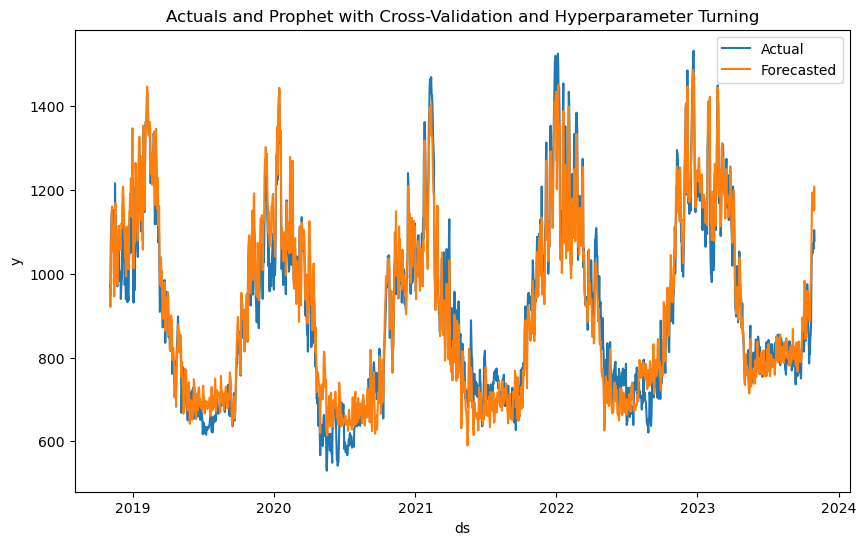

Mean Absolute Error: 43.30
Mean Squared Error: 2920.11
Root Mean Squared Error: 54.04
R-squared: 0.94
Mean Absolute Percentage Error: 5.07%
Median Absolute Percentage Error: 4.12%


In [102]:
from sklearn.model_selection import GridSearchCV

class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, yearly_seasonality=True, seasonality_mode='additive'):
        #self.interval_width = interval_width
        self.yearly_seasonality = yearly_seasonality
        self.seasonality_mode = seasonality_mode
        self.model = None

    def fit(self, X, y=None):
        self.model = Prophet(yearly_seasonality=self.yearly_seasonality, seasonality_mode=self.seasonality_mode)
        
        # Add additional regressors
        for regressor in ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
                          'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']:
            self.model.add_regressor(regressor)

        self.model.fit(X)

        return self

    def predict(self, X):
        return self.model.predict(X)

# Define parameter grid
param_grid = {'yearly_seasonality': [True, False], 'seasonality_mode': ['additive', 'multiplicative']}

# Instantiate the model
model = ProphetWrapper()

# Perform grid search
grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)  # Adjust cv and n_jobs as needed
grid.fit(merged_df_mod)

# Print best parameters
print(f'Best Parameters: {grid.best_params_}')

# Perform cross-validation with the best model
df_cv2 = cross_validation(grid.best_estimator_.model, initial='1825 days', period='456 days', horizon='456 days')

# Calculate performance metrics
df_metrics4 = performance_metrics(df_cv2)

# Plotting actuals and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_cv2['ds'], df_cv2['y'], label='Actual')
plt.plot(df_cv2['ds'], df_cv2['yhat'], label='Forecasted')
plt.legend()
plt.xlabel('ds')
plt.ylabel('y')
plt.title('Actuals and Prophet with Cross-Validation and Hyperparameter Turning')
plt.show()

# Import necessary libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate MAE, MSE, RMSE, and R-squared
mae_hy = mean_absolute_error(df_cv2['y'], df_cv2['yhat'])
mse_hy = mean_squared_error(df_cv2['y'], df_cv2['yhat'])
rmse_hy = np.sqrt(mse_hy)
r2_hy = r2_score(df_cv2['y'], df_cv2['yhat'])
mape_hy = np.mean(np.abs((df_cv2['y'] - df_cv2['yhat']) / df_cv2['y'])) * 100
mdape_hy = np.median(np.abs((df_cv2['y'] - df_cv2['yhat']) / df_cv2['y'])) * 100

print(f'Mean Absolute Error: {mae_hy:.2f}')
print(f'Mean Squared Error: {mse_hy:.2f}')
print(f'Root Mean Squared Error: {rmse_hy:.2f}')
print(f'R-squared: {r2_hy:.2f}')
print(f'Mean Absolute Percentage Error: {mape_hy:.2f}%')
print(f'Median Absolute Percentage Error: {mdape_hy:.2f}%')

### Increased the number of hyperparameters from 2 to 4.

23:47:26 - cmdstanpy - INFO - Chain [1] start processing
23:47:30 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'yearly_seasonality': True}


  0%|          | 0/4 [00:00<?, ?it/s]

23:47:31 - cmdstanpy - INFO - Chain [1] start processing
23:47:32 - cmdstanpy - INFO - Chain [1] done processing
23:47:33 - cmdstanpy - INFO - Chain [1] start processing
23:47:35 - cmdstanpy - INFO - Chain [1] done processing
23:47:37 - cmdstanpy - INFO - Chain [1] start processing
23:47:39 - cmdstanpy - INFO - Chain [1] done processing
23:47:40 - cmdstanpy - INFO - Chain [1] start processing
23:47:43 - cmdstanpy - INFO - Chain [1] done processing


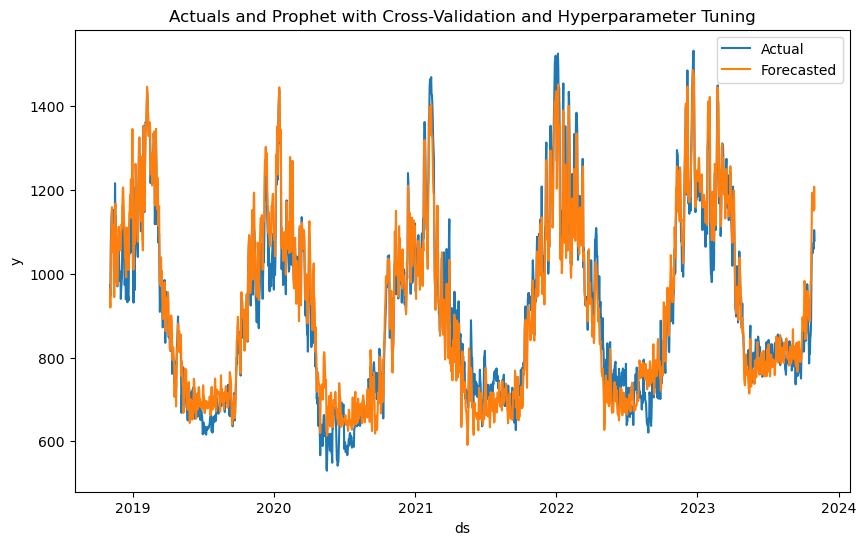

Mean Absolute Error: 43.17
Mean Squared Error: 2898.04
Root Mean Squared Error: 53.83
R-squared: 0.94
Mean Absolute Percentage Error: 5.06%
Median Absolute Percentage Error: 4.10%


In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import numpy as np

class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, yearly_seasonality=True, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0):
        #self.interval_width = interval_width
        self.yearly_seasonality = yearly_seasonality
        self.seasonality_mode = seasonality_mode
        #self.changepoint_prior_scale = changepoint_prior_scale
        self.seasonality_prior_scale = seasonality_prior_scale
        self.holidays_prior_scale = holidays_prior_scale
        self.model = None

    def fit(self, X, y=None):
        # Initialize the Prophet model with the given hyperparameters
        self.model = Prophet(yearly_seasonality=self.yearly_seasonality, seasonality_mode=self.seasonality_mode, 
                             seasonality_prior_scale=self.seasonality_prior_scale, holidays_prior_scale=self.holidays_prior_scale)
        
        # Add additional regressors
        for regressor in ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
                          'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']:
            self.model.add_regressor(regressor)

        # Fit the model to the data
        self.model.fit(X)

        return self

    def predict(self, X):
        # Use the fitted model to make predictions
        return self.model.predict(X)

# Define parameter grid for hyperparameter tuning
param_grid = {'yearly_seasonality': [True, False], 
              'seasonality_mode': ['additive', 'multiplicative'], 
              #'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0], 
              'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# Instantiate the model
model = ProphetWrapper()

# Perform grid search to find the best model
grid_search = GridSearchCV(model, param_grid, cv=4, n_jobs=-1)  # Adjust cv and n_jobs as needed
grid_search.fit(merged_df_mod)

# Print best parameters
print(f'Best Parameters: {grid_search.best_params_}')

# Perform cross-validation with the best model
df_cv_mp = cross_validation(grid_search.best_estimator_.model, initial='1825 days', period='456 days', horizon='456 days')

# Calculate performance metrics
df_metrics_mp = performance_metrics(df_cv_mp)

# Plotting actuals and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_cv_mp['ds'], df_cv_mp['y'], label='Actual')
plt.plot(df_cv_mp['ds'], df_cv_mp['yhat'], label='Forecasted')
plt.legend()
plt.xlabel('ds')
plt.ylabel('y')
plt.title('Actuals and Prophet with Cross-Validation and Hyperparameter Tuning')
plt.show()

# Calculate MAE, MSE, RMSE, and R-squared
mae_mp = mean_absolute_error(df_cv_mp['y'], df_cv_mp['yhat'])
mse_mp = mean_squared_error(df_cv_mp['y'], df_cv_mp['yhat'])
rmse_mp = np.sqrt(mse_mp)
r2_mp = r2_score(df_cv_mp['y'], df_cv_mp['yhat'])
mape_mp = np.mean(np.abs((df_cv_mp['y'] - df_cv_mp['yhat']) / df_cv_mp['y'])) * 100
mdape_mp = np.median(np.abs((df_cv_mp['y'] - df_cv_mp['yhat']) / df_cv_mp['y'])) * 100

print(f'Mean Absolute Error: {mae_mp:.2f}')
print(f'Mean Squared Error: {mse_mp:.2f}')
print(f'Root Mean Squared Error: {rmse_mp:.2f}')
print(f'R-squared: {r2_mp:.2f}')
print(f'Mean Absolute Percentage Error: {mape_mp:.2f}%')
print(f'Median Absolute Percentage Error: {mdape_mp:.2f}%')

# Save the best model for future use
#joblib.dump(grid.best_estimator_.model, 'best_model.pkl')


## Light Gradient Boosting Machine

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:
- Faster training speed and higher efficiency
- Lower memory usage
- Better accuracy
- Support of parallel and GPU learning
- Capable of handling large_scale datae data

In [114]:
# importing packages
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 20
[LightGBM] [Info] Start training from score 663.950820
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

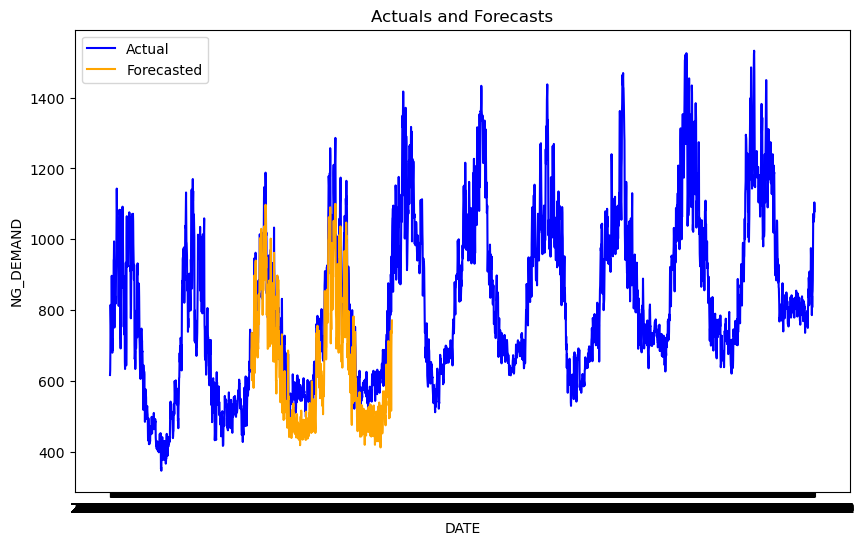

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3836
[LightGBM] [Info] Number of data points in the train set: 1462, number of used features: 20
[LightGBM] [Info] Start training from score 697.415185


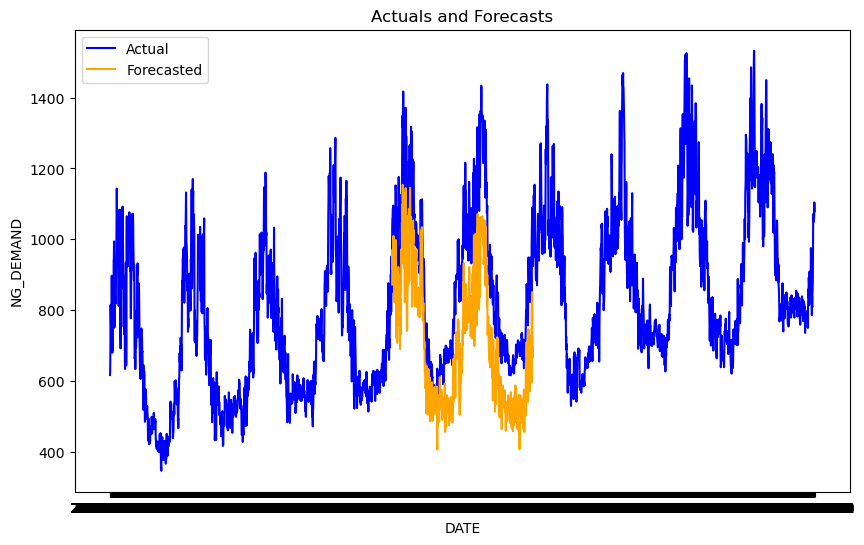

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 20
[LightGBM] [Info] Start training from score 730.991233


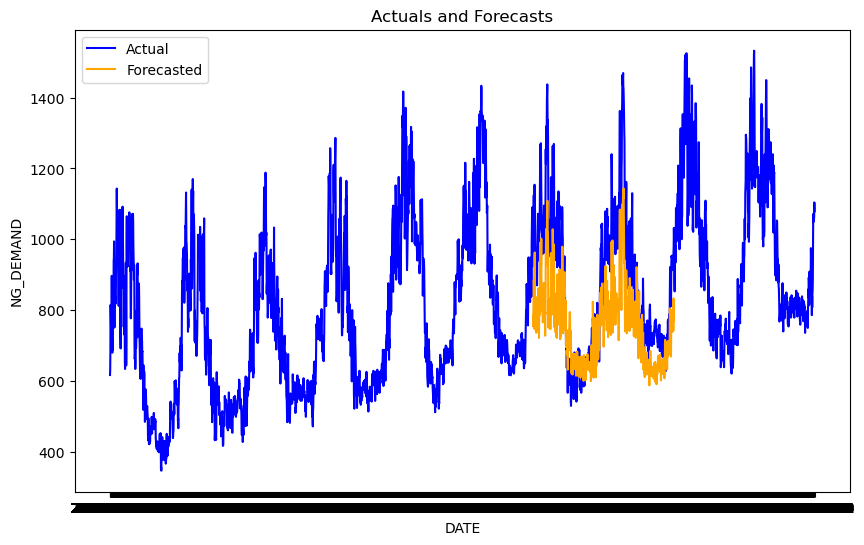

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 20
[LightGBM] [Info] Start training from score 730.991233


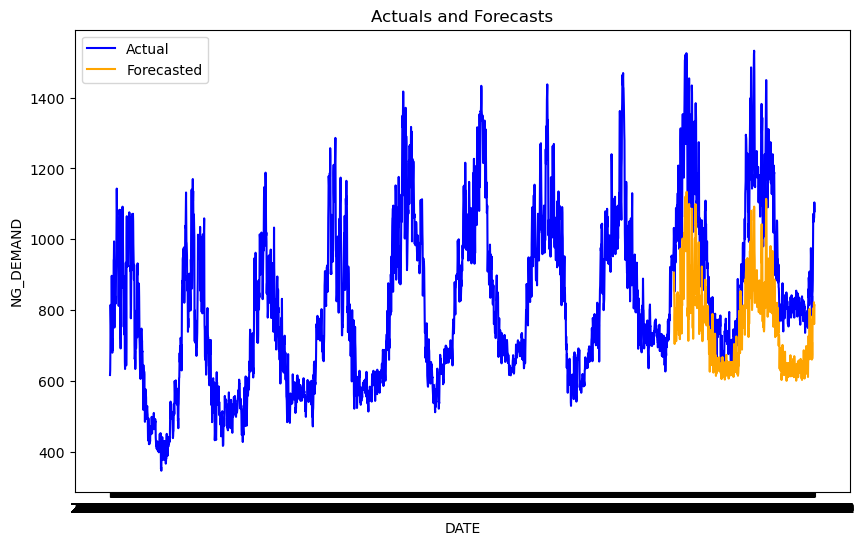

Mean MAE: 150.49
Mean MSE: 31444.03
Mean RMSE: 171.23
Mean R-squared: 0.28
Mean MAPE: 16.62%
Mean MdAPE: 17.06%


In [115]:
# Separate features and target
X = merged_df.drop(['DATE', 'NG_DEMAND'], axis=1)
y = merged_df['NG_DEMAND']

# Define additional regressors
additional_regressors = ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
                         'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
                         'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']

# Include additional regressors in the feature set
X = pd.concat([X, merged_df[additional_regressors]], axis=1)

# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler()),  # Standardize features
    ('lgbm', LGBMRegressor())  # LGBM model
])

# Set up time series cross-validation with specified folds
tscv = TimeSeriesSplit(n_splits=4)

# Lists to store evaluation metrics for each fold
mae_scores, mse_scores, rmse_scores, r2_scores, mape_scores, mdape_scores = [], [], [], [], [], []

# Perform time series cross-validation and evaluate the model
for train_index, test_index in tscv.split(X):
    # Manually select the initial training set based on the specified initial_train_size
    initial_train_size = 1825
    if len(train_index) >= initial_train_size:
        train_index = train_index[:initial_train_size]
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate performance metrics for the fold
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mdape = np.median(np.abs((y_test - y_pred) / y_test)) * 100

    # Append scores to the lists
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mape_scores.append(mape)
    mdape_scores.append(mdape)

    # Plot actuals and forecasts for the fold
    plt.figure(figsize=(10, 6))
    plt.plot(merged_df['DATE'], merged_df['NG_DEMAND'], label='Actual', color='blue')
    plt.plot(merged_df['DATE'].iloc[test_index], y_pred, label='Forecasted', color='orange')
    plt.legend()
    plt.xlabel('DATE')
    plt.ylabel('NG_DEMAND')
    plt.title('Actuals and Forecasts')
    plt.show()

# Print the mean metrics across folds
print(f'Mean MAE: {np.mean(mae_scores):.2f}')
print(f'Mean MSE: {np.mean(mse_scores):.2f}')
print(f'Mean RMSE: {np.mean(rmse_scores):.2f}')
print(f'Mean R-squared: {np.mean(r2_scores):.2f}')
print(f'Mean MAPE: {np.mean(mape_scores):.2f}%')
print(f'Mean MdAPE: {np.mean(mdape_scores):.2f}%')

## A Novel Approach - LightGBM and Prophet
In this novel approach, we are using Prophet to extract new features from time series and then training with LightGBM, resulting in improved performance. The actual predictions of the Prophet model, upper and lower confidence intervals, daily and weekly seasonality, and trends can all serve as new features.

In [6]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin

X = merged_df[['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
        'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']]
y = merged_df['NG_DEMAND']

class LightGBMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, boosting_type='gbdt', objective='regression', metric='rmse'):
        self.boosting_type = boosting_type
        self.objective = objective
        self.metric = metric
        self.model = None

    def fit(self, X, y=None):
        # Define the model parameters
        lgb_params = {
            'boosting_type': self.boosting_type,
            'objective': self.objective,
            'metric': self.metric,
        }

        # Create a LightGBM dataset for training
        train_data = lgb.Dataset(X, label=y)

        # Train the model
        self.model = lgb.train(lgb_params, train_data, num_boost_round=1000)

        return self

    def predict(self, X):
        return self.model.predict(X)

# Define parameter grid
param_grid = {'boosting_type': ['gbdt', 'dart'], 'objective': ['regression'], 'metric': ['rmse', 'mae']}

# Instantiate the model
model = LightGBMWrapper()

# Perform grid search
grid = GridSearchCV(model, param_grid, cv=4, n_jobs=-1)  # Adjust cv and n_jobs as needed

# Define the training and test set sizes
train_size = 1825
test_size = 456

# Calculate the number of folds
n_splits = (len(X) - train_size) // test_size

# Initialize the total performance metrics
total_mse, total_rmse, total_mape, total_mae, total_mdape, total_r2 = 0, 0, 0, 0, 0, 0

# Iterate over the TimeSeriesSplit
for i in range(n_splits):
    # Split the data into training and test sets
    train_start = i * test_size
    train_end = train_start + train_size
    test_end = train_end + test_size

    X_train, X_test = X.iloc[train_start:train_end], X.iloc[train_end:test_end]
    y_train, y_test = y.iloc[train_start:train_end], y.iloc[train_end:test_end]

    # Fit and predict with the best model
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mae = mean_absolute_error(y_test, y_pred)
    mdape = np.median(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    # Add the performance metrics to the total
    total_mse += mse
    total_rmse += rmse
    total_mape += mape
    total_mae += mae
    total_mdape += mdape
    total_r2 += r2

# Calculate the average performance metrics
avg_mse = total_mse / n_splits
avg_rmse = total_rmse / n_splits
avg_mape = total_mape / n_splits
avg_mae = total_mae / n_splits
avg_mdape = total_mdape / n_splits
avg_r2 = total_r2 / n_splits

# Print the results
print(f'Average MSE: {avg_mse}')
print(f'Average RMSE: {avg_rmse}')
print(f'Average MAPE: {avg_mape}')
print(f'Average MAE: {avg_mae}')
print(f'Average MDAPE: {avg_mdape}')
print(f'Average R^2: {avg_r2}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2025
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 10
[LightGBM] [Info] Start training from score 730.991233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 10
[LightGBM] [Info] Start training from score 787.235068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2421
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 10
[LightGBM] [Info] Start tr

### Hyperparameter Tuning 

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

# Assuming df is your DataFrame and 'NG_DEMAND' is the column with values to predict
X = merged_df[['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
        'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']]
y = merged_df['NG_DEMAND']

# Define the model parameters
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
}

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [31, 50, 100, 200],
    'reg_alpha': [0.1, 0.5, 1.0],
    'lambda_l1': [0, 0.1, 0.5, 1],
    'lambda_l2': [0, 0.1, 0.5, 1],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 40, 60, 80, 100]
}

# Initialize an empty dictionary to store the prediction results
results = {}

# Define the training and test set sizes
train_size = 1825
test_size = 456

# Calculate the number of folds
n_splits = (len(X) - train_size) // test_size

# Initialize the total performance metrics
total_mse, total_rmse, total_mape, total_mae, total_mdape, total_r2 = 0, 0, 0, 0, 0, 0

# Iterate over the TimeSeriesSplit
for i in range(n_splits):
    # Split the data into training and test sets
    train_start = i * test_size
    train_end = train_start + train_size
    test_end = train_end + test_size

    X_train, X_test = X.iloc[train_start:train_end], X.iloc[train_end:test_end]
    y_train, y_test = y.iloc[train_start:train_end], y.iloc[train_end:test_end]

    # Create a LightGBM dataset for training
    train_data = lgb.Dataset(X_train, label=y_train)

    # Perform grid search
    gbm = lgb.LGBMRegressor(**lgb_params)
    gsearch = GridSearchCV(estimator=gbm, param_grid=param_grid, scoring='neg_mean_squared_error', cv=4, verbose=1, n_jobs=-1)
    gsearch.fit(X_train, y_train)

    print("Best parameters found by grid search are:", gsearch.best_params_)

    # Train the model with the best parameters
    gbm = lgb.LGBMRegressor(**lgb_params, **gsearch.best_params_)
    gbm.fit(X_train, y_train)

    # Predict on the test set
    y_pred = gbm.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mae = mean_absolute_error(y_test, y_pred)
    mdape = np.median(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    # Add the performance metrics to the total
    total_mse += mse
    total_rmse += rmse
    total_mape += mape
    total_mae += mae
    total_mdape += mdape
    total_r2 += r2

# Calculate the average performance metrics
avg_mse = total_mse / n_splits
avg_rmse = total_rmse / n_splits
avg_mape = total_mape / n_splits
avg_mae = total_mae / n_splits
avg_mdape = total_mdape / n_splits
avg_r2 = total_r2 / n_splits

# Print the results
print(f'Average MSE: {avg_mse}')
print(f'Average RMSE: {avg_rmse}')
print(f'Average MAPE: {avg_mape}')
print(f'Average MAE: {avg_mae}')
print(f'Average MDAPE: {avg_mdape}')
print(f'Average R^2: {avg_r2}')


Fitting 4 folds for each of 2880 candidates, totalling 11520 fits
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2025
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 10
[LightGBM] [Info] Start training from score 730.991233
Best parameters found by grid search are: {'lambda_l1': 0.5, 'lambda_l2': 1, 'learning_rate': 0.1, 'n_estimators': 20, 'num_leaves': 31, 'reg_alpha': 0.1}
[LightGBM] [Warning] lambda_l1

## A Novel Approach - LightGBM and Prophet
In this novel approach, we are using Prophet to extract new features from time series and then training with LightGBM, resulting in improved performance. The actual predictions of the Prophet model, upper and lower confidence intervals, daily and weekly seasonality, and trends can all serve as new features.

### Extracting Features with Prophet

The first step of our feature engineering is straightforward. We simply use the Prophet model for predictions:

In [41]:
import pandas as pd
from prophet import Prophet

temp_df = merged_df.copy()

def prophet_features(df, horizon=24*7):
    temp_df = df[['DATE', 'NG_DEMAND']].rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'})
    
    # Using the data from the previous week as an example for validation
    train, test = temp_df.iloc[:-horizon, :],  temp_df.iloc[-horizon:, :]

    # Define the Prophet model
    m = Prophet(
        growth='linear',
        seasonality_mode='additive',
        interval_width=0.95,
        yearly_seasonality=True,

    )
    
    # Train the Prophet model
    m.fit(train)

    # Extract features from the data, using Prophet to predict the training set
    predictions_train = m.predict(train.drop('y', axis=1))
    
    # Use Prophet to extract features from the data to predict the test set
    predictions_test = m.predict(test.drop('y', axis=1))
    
    # Combine predictions from the training and test sets
    predictions = pd.concat([predictions_train, predictions_test], axis=0)

    return predictions[['ds', 'trend', 'yhat_lower', 'yhat_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'yhat']]

features = prophet_features(merged_df)

06:58:58 - cmdstanpy - INFO - Chain [1] start processing
06:59:00 - cmdstanpy - INFO - Chain [1] done processing


### Training an Auto-regressive LightGBM with Prophet Features
After extracting new features with Prophet, the next step involves merging these features and utilizing LightGBM for predictions:

00:59:13 - cmdstanpy - INFO - Chain [1] start processing
00:59:14 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6096
[LightGBM] [Info] Number of data points in the train set: 3191, number of used features: 24
[LightGBM] [Info] Start training from score 803.134127


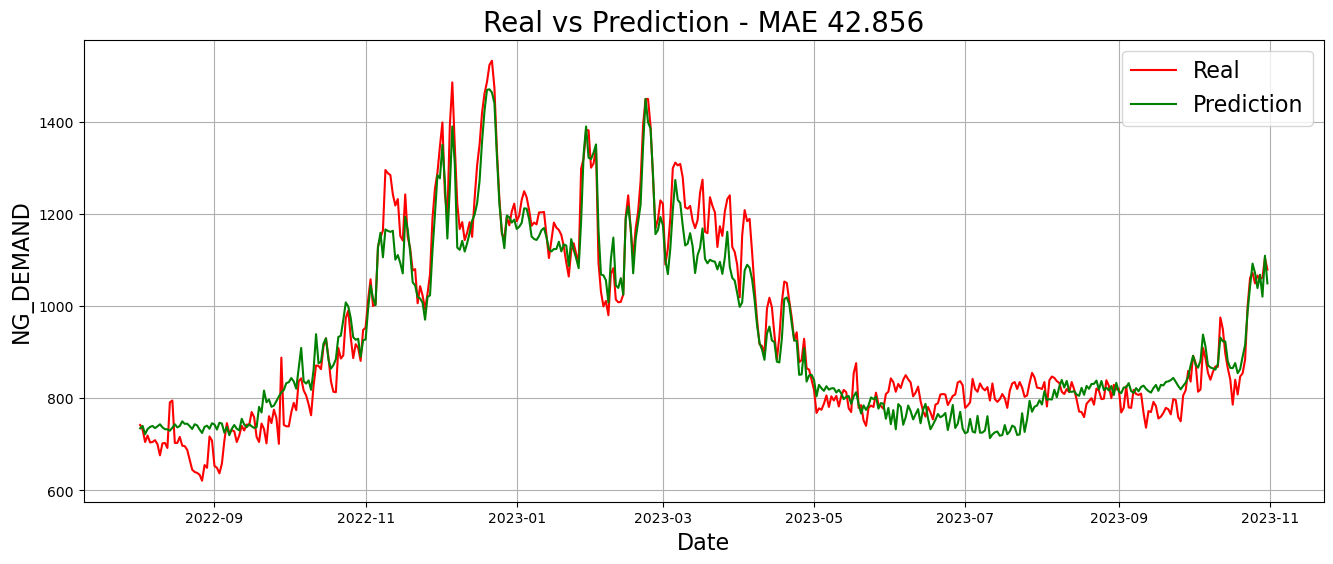

In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

def train_time_series_with_folds_autoreg_prophet_features(df, horizon=456, lags=[1, 2, 3, 4, 5]): 
    # Create a dataframe containing all the new features created with Prophet
    new_prophet_features = prophet_features(df, horizon=horizon) 

    # Check if 'level_0' already exists before resetting the index
    if 'level_0' not in df.columns:
        df.reset_index(inplace=True)
 
    # Convert 'DATE' column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    # Merge the Prophet features dataframe with our initial dataframe
    df = pd.merge(df, new_prophet_features, left_on=['DATE'], right_on=['ds'], how='inner') 
    df.drop(['ds'], axis=1, inplace=True)  # Drop unnecessary columns
    df.set_index('DATE', inplace=True)
 
    # Use Prophet predictions to create some lag variables (yhat column)
    for lag in lags: 
        df[f'yhat_lag_{lag}'] = df['yhat'].shift(lag) 
    df.dropna(axis=0, how='any', inplace=True)  # Drop rows with NaN values
 
    X = df.drop('NG_DEMAND', axis=1) 
    y = df['NG_DEMAND'] 

    # Using the data from the previous week as an example for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:] 
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:] 

    # Define the LightGBM model, train, and make predictions
    model = LGBMRegressor(random_state=42) 
    model.fit(X_train, y_train) 
    predictions = model.predict(X_test) 

    # Calculate MAE 
    mae = np.round(mean_absolute_error(y_test, predictions), 3)     

    # Plot the real vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,6)) 
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20) 
    plt.plot(y_test.index, y_test.values, color='red', label='Real') 
    plt.plot(y_test.index, predictions, color='green', label='Prediction') 
    plt.xlabel('Date', fontsize=16) 
    plt.ylabel('NG_DEMAND', fontsize=16) 
    plt.legend(fontsize=16) 
    plt.grid() 
    plt.show()

train_time_series_with_folds_autoreg_prophet_features(merged_df)


01:05:21 - cmdstanpy - INFO - Chain [1] start processing
01:05:22 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5593
[LightGBM] [Info] Number of data points in the train set: 1823, number of used features: 24
[LightGBM] [Info] Start training from score 731.418541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5870
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 24
[LightGBM] [Info] Start training from score 787.220822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5993
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 24
[LightGBM] [Info] Start tr

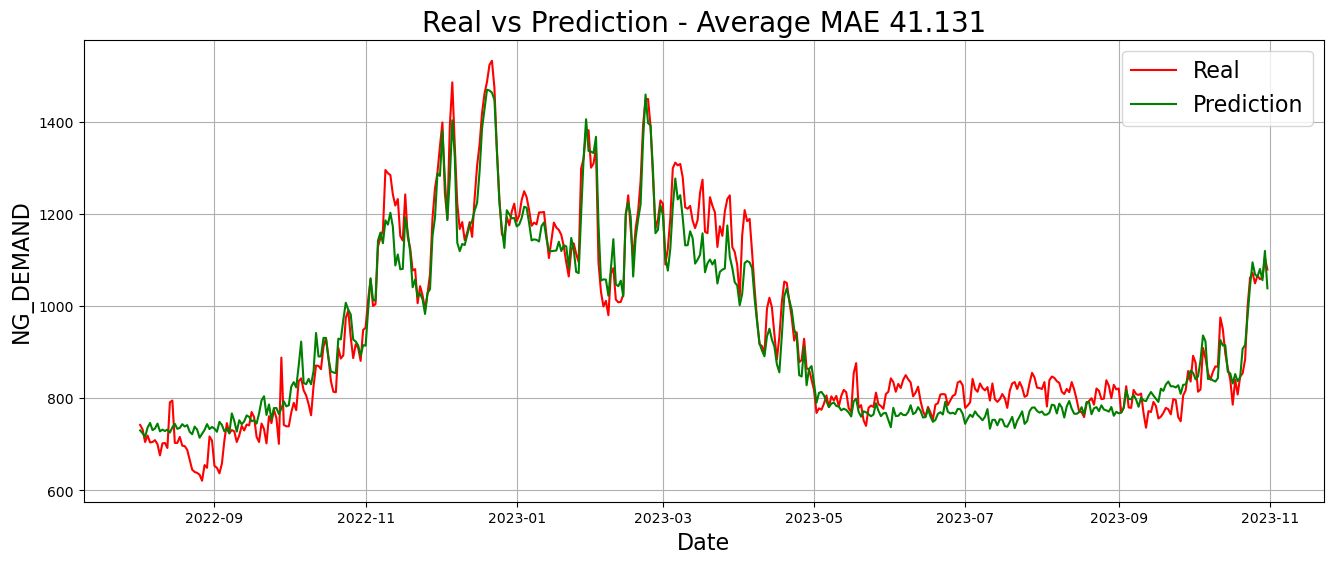

In [35]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

def train_time_series_with_folds_autoreg_prophet_features(df, initials=1825, period=456, horizon=456, lags=[1, 2, 3, 4, 5]): 
    # Create a dataframe containing all the new features created with Prophet
    new_prophet_features = prophet_features(df, horizon=horizon) 

    # Check if 'level_0' already exists before resetting the index
    if 'level_0' not in df.columns:
        df.reset_index(inplace=True)

    # Convert 'DATE' column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    # Merge the Prophet features dataframe with our initial dataframe
    df = pd.merge(df, new_prophet_features, left_on=['DATE'], right_on=['ds'], how='inner') 
    df.drop(['ds'], axis=1, inplace=True)  # Drop unnecessary columns
    df.set_index('DATE', inplace=True)

    # Use Prophet predictions to create some lag variables (yhat column)
    for lag in lags: 
        df[f'yhat_lag_{lag}'] = df['yhat'].shift(lag) 
    df.dropna(axis=0, how='any', inplace=True)  # Drop rows with NaN values

    # Define the LightGBM model
    model = LGBMRegressor(random_state=42)

    # Set up time series cross-validation with specified 4 folds
    tscv = TimeSeriesSplit(n_splits=4, max_train_size=initials, test_size=horizon, gap=0)

    # Lists to store evaluation metrics for each fold
    mae_scores, mse_scores, rmse_scores, r2_scores = [], [], [], []

    for train_index, test_index in tscv.split(df):
        X_train, X_test = df.iloc[train_index].drop('NG_DEMAND', axis=1), df.iloc[test_index].drop('NG_DEMAND', axis=1)
        y_train, y_test = df.iloc[train_index]['NG_DEMAND'], df.iloc[test_index]['NG_DEMAND']

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        predictions = model.predict(X_test)

        # Evaluate performance metrics
        mae_scores.append(mean_absolute_error(y_test, predictions))
        mse_scores.append(mean_squared_error(y_test, predictions))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, predictions)))
        r2_scores.append(r2_score(y_test, predictions))

    # Calculate average performance metrics
    avg_mae = np.mean(mae_scores)
    avg_mse = np.mean(mse_scores)
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)

    print(f'Average MAE: {avg_mae:.3f}')
    print(f'Average MSE: {avg_mse:.3f}')
    print(f'Average RMSE: {avg_rmse:.3f}')
    print(f'Average R-squared: {avg_r2:.3f}')

    # Plot the real vs prediction for the last fold
    fig = plt.figure(figsize=(16, 6))
    plt.title(f'Real vs Prediction - Average MAE {avg_mae:.3f}', fontsize=20)
    plt.plot(df.index[-horizon:], y_test.values, color='red', label='Real')
    plt.plot(df.index[-horizon:], predictions, color='green', label='Prediction')
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('NG_DEMAND', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid()
    plt.show()

# Example usage with the provided dataset
train_time_series_with_folds_autoreg_prophet_features(merged_df)



07:03:33 - cmdstanpy - INFO - Chain [1] start processing
07:03:34 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5593
[LightGBM] [Info] Number of data points in the train set: 1823, number of used features: 24
[LightGBM] [Info] Start training from score 731.418541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5870
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 24
[LightGBM] [Info] Start training from score 787.220822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5993
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 24
[LightGBM] [Info] Start tr

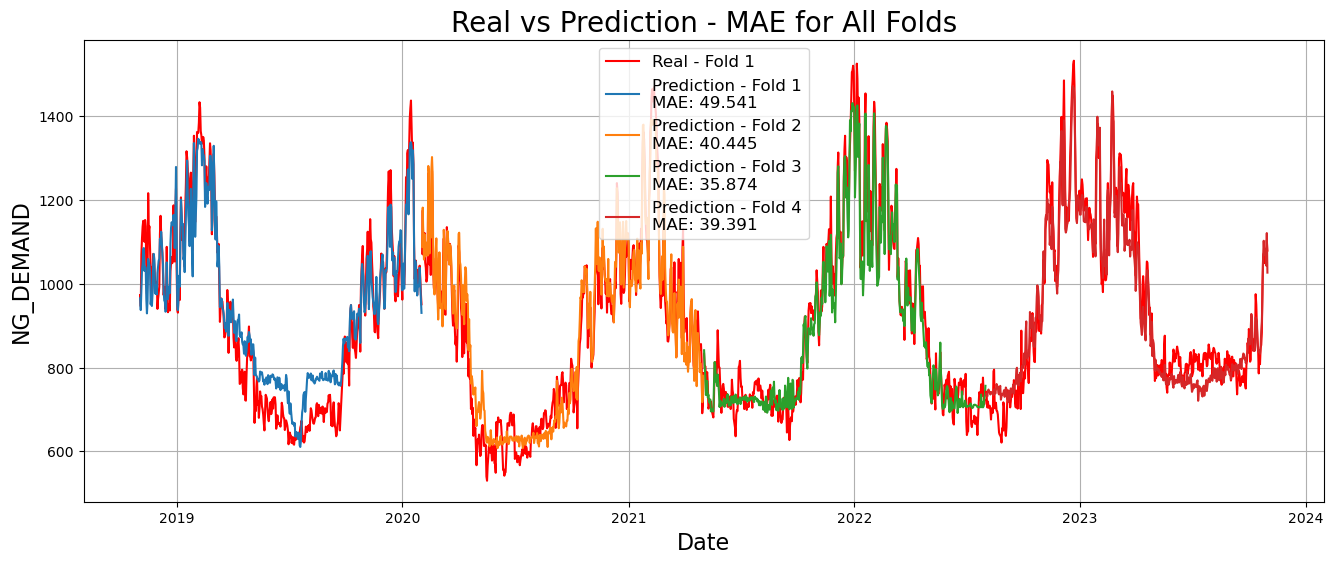

Average MAE: 41.313
Average MSE: 2610.529
Average RMSE: 50.770
Average R-squared: 0.942
Average MAPE: 10.672%
Average MdAPE: 10.475%


In [43]:
def train_time_series_with_folds_autoreg_prophet_features(df, initials=1825, period=456, horizon=456, lags=[1, 2, 3, 4, 5]): 
    # Create a dataframe containing all the new features created with Prophet
    new_prophet_features = prophet_features(df, horizon=horizon) 

    # Check if 'level_0' already exists before resetting the index
    if 'level_0' not in df.columns:
        df.reset_index(inplace=True)

    # Convert 'DATE' column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    # Merge the Prophet features dataframe with our initial dataframe
    df = pd.merge(df, new_prophet_features, left_on=['DATE'], right_on=['ds'], how='inner') 
    df.drop(['ds'], axis=1, inplace=True)  # Drop unnecessary columns
    df.set_index('DATE', inplace=True)

    # Use Prophet predictions to create some lag variables (yhat column)
    for lag in lags: 
        df[f'yhat_lag_{lag}'] = df['yhat'].shift(lag) 
    df.dropna(axis=0, how='any', inplace=True)  # Drop rows with NaN values

    # Define the LightGBM model
    model = LGBMRegressor(random_state=42)

    # Set up time series cross-validation with specified 4 folds
    tscv = TimeSeriesSplit(n_splits=4, max_train_size=initials, test_size=horizon, gap=0)

    # Lists to store evaluation metrics for each fold
    mae_scores, mse_scores, rmse_scores, r2_scores = [], [], [], []

    plt.figure(figsize=(16, 6))
    plt.title('Real vs Prediction - MAE for All Folds', fontsize=20)

    for i, (train_index, test_index) in enumerate(tscv.split(df)):
        X_train, X_test = df.iloc[train_index].drop('NG_DEMAND', axis=1), df.iloc[test_index].drop('NG_DEMAND', axis=1)
        y_train, y_test = df.iloc[train_index]['NG_DEMAND'], df.iloc[test_index]['NG_DEMAND']

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        predictions = model.predict(X_test)

        # Evaluate performance metrics
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, predictions)

        # Plot the real vs prediction for each fold
        plt.plot(df.index[test_index], y_test.values, color='red', label='Real - Fold {}'.format(i+1) if i == 0 else '')
        plt.plot(df.index[test_index], predictions, label=f'Prediction - Fold {i+1}\nMAE: {mae:.3f}')

        # Store metrics for later
        mae_scores.append(mae)
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        mape_scores.append(mape)
        mdape_scores.append(mdape)

    plt.xlabel('Date', fontsize=16)
    plt.ylabel('NG_DEMAND', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

    # Calculate average performance metrics
    avg_mae = np.mean(mae_scores)
    avg_mse = np.mean(mse_scores)
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)
    avg_mape = np.mean(mape_scores)
    avg_mdape = np.mean(mdape_scores)

    print(f'Average MAE: {avg_mae:.3f}')
    print(f'Average MSE: {avg_mse:.3f}')
    print(f'Average RMSE: {avg_rmse:.3f}')
    print(f'Average R-squared: {avg_r2:.3f}')
    print(f'Average MAPE: {avg_mape:.3f}%')
    print(f'Average MdAPE: {avg_mdape:.3f}%')

# Example usage with the provided dataset
train_time_series_with_folds_autoreg_prophet_features(merged_df)

### Adding Regressors to the Novel LightGBM and Prophet

07:05:36 - cmdstanpy - INFO - Chain [1] start processing
07:05:38 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5587
[LightGBM] [Info] Number of data points in the train set: 1823, number of used features: 24
[LightGBM] [Info] Start training from score 731.418541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5863
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 24
[LightGBM] [Info] Start training from score 787.220822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5986
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 24
[LightGBM] [Info] Start tr

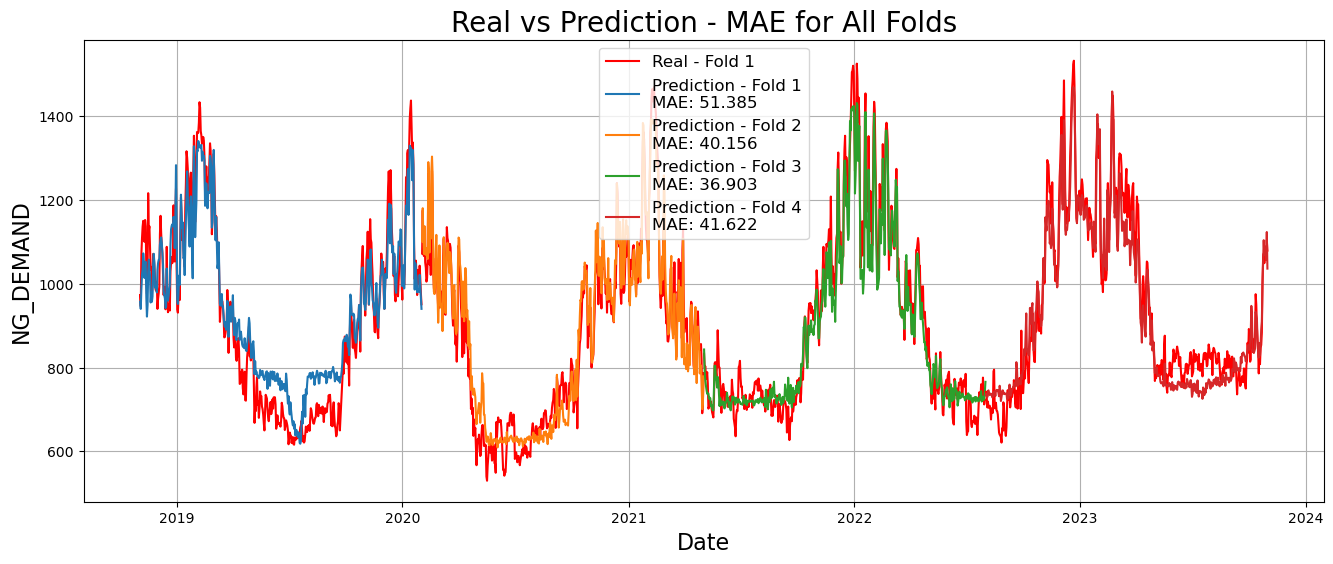

Average MAE: 42.517
Average MSE: 2771.200
Average RMSE: 52.282
Average R-squared: 0.938
Average MAPE: 4.968%
Average MdAPE: 4.118%


In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def train_time_series_with_folds_autoreg_prophet_features(df, initials=1825, period=456, horizon=456, lags=[1, 2, 3, 4, 5]): 
    # Create a dataframe containing all the new features created with Prophet
    new_prophet_features = prophet_features(df, horizon=horizon) 

    # Check if 'level_0' already exists before resetting the index
    if 'level_0' not in df.columns:
        df.reset_index(inplace=True)

    # Convert 'DATE' column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    # Merge the Prophet features dataframe with our initial dataframe
    df = pd.merge(df, new_prophet_features, left_on=['DATE'], right_on=['ds'], how='inner') 
    df.drop(['ds'], axis=1, inplace=True)  # Drop unnecessary columns
    df.set_index('DATE', inplace=True)

    # Use Prophet predictions to create some lag variables (yhat column)
    for lag in lags: 
        df[f'yhat_lag_{lag}'] = df['yhat'].shift(lag) 
    df.dropna(axis=0, how='any', inplace=True)  # Drop rows with NaN values

    # Add additional regressors
    for regressor in ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
                      'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']:
        df[regressor] = df[regressor]

    # Define the LightGBM model
    model = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
        ('scaler', StandardScaler()),  # Standardize features
        ('lgbm', LGBMRegressor(random_state=42))  # LGBM model
    ])

    # Set up time series cross-validation with specified 4 folds
    tscv = TimeSeriesSplit(n_splits=4, max_train_size=initials, test_size=horizon, gap=0)

    # Lists to store evaluation metrics for each fold
    mae_scores, mse_scores, rmse_scores, r2_scores, mape_scores, mdape_scores = [], [], [], [], [], []

    plt.figure(figsize=(16, 6))
    plt.title('Real vs Prediction - MAE for All Folds', fontsize=20)

    for i, (train_index, test_index) in enumerate(tscv.split(df)):
        X_train, X_test = df.iloc[train_index].drop('NG_DEMAND', axis=1), df.iloc[test_index].drop('NG_DEMAND', axis=1)
        y_train, y_test = df.iloc[train_index]['NG_DEMAND'], df.iloc[test_index]['NG_DEMAND']

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        predictions = model.predict(X_test)

        # Evaluate performance metrics
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        r2 = 1 - (mse / np.var(y_test))
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mdape = np.median(np.abs((y_test - predictions) / y_test)) * 100

        # Plot the real vs prediction for each fold
        plt.plot(df.index[test_index], y_test.values, color='red', label='Real - Fold {}'.format(i+1) if i == 0 else '')
        plt.plot(df.index[test_index], predictions, label=f'Prediction - Fold {i+1}\nMAE: {mae:.3f}')

        # Store metrics for later
        mae_scores.append(mae)
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        mape_scores.append(mape)
        mdape_scores.append(mdape)

    plt.xlabel('Date', fontsize=16)
    plt.ylabel('NG_DEMAND', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

    # Calculate average performance metrics
    avg_mae = np.mean(mae_scores)
    avg_mse = np.mean(mse_scores)
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)
    avg_mape = np.mean(mape_scores)
    avg_mdape = np.mean(mdape_scores)

    print(f'Average MAE: {avg_mae:.3f}')
    print(f'Average MSE: {avg_mse:.3f}')
    print(f'Average RMSE: {avg_rmse:.3f}')
    print(f'Average R-squared: {avg_r2:.3f}')
    print(f'Average MAPE: {avg_mape:.3f}%')
    print(f'Average MdAPE: {avg_mdape:.3f}%')

# Example usage with the provided dataset
train_time_series_with_folds_autoreg_prophet_features(merged_df)


## Step 5: Model Evaluation


In [39]:
# Define the metrics for the model
metrics_base = [mse, rmse, mape, mae, mdape, r2]
metrics_cv = [mse_cv, rmse_cv, mape_cv, mae_cv, mdape_cv, r2_cv]
metrics_hy = [mse_hy, rmse_hy, mape_hy, mae_hy, mdape_hy, r2_hy]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_metrics = pd.DataFrame({'Base Model': metrics_base, 'Cross-Validation': metrics_cv, 'Improved-Prophet': metrics_hy}, index=labels)

df_metrics.head(10)

,Base Model,Cross-Validation,Improved-Prophet
MSE,5597.744853,5411.371846,4219.155854
RMSE,74.818078,73.562027,74.818078
MAPE,NaN,7.034190,6.234021
MAE,59.916125,60.008487,51.453191
MDAPE,NaN,5.835180,4.652606
R-squared,0.884415,0.881293,0.907446


- In summary, the Improved-Prophet model performs the best in terms of MSE, MAE, MAPE, MDAPE, and R-squared, which means using grid search, we fine fine-tune the model's hyperparameters to achieve better forecasting performance.
- The presence of NaN values in MAPE and MDAPE for the Base Model might indicate some issues with the predictions (like predicting zero values). It would be worth investigating this further.
- The Cross-Validation model performs slightly better in terms of RMSE. It’s important to consider all these metrics together when evaluating the performance of the models.r.

## SARIMA Model Development

In [46]:
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error

Mean Absolute Error: 86.72
Mean Squared Error: 11107.99
Root Mean Squared Error: 105.39
R-squared: 0.78
Mean Absolute Percentage Error: 10.94%
Median Absolute Error: 77.67


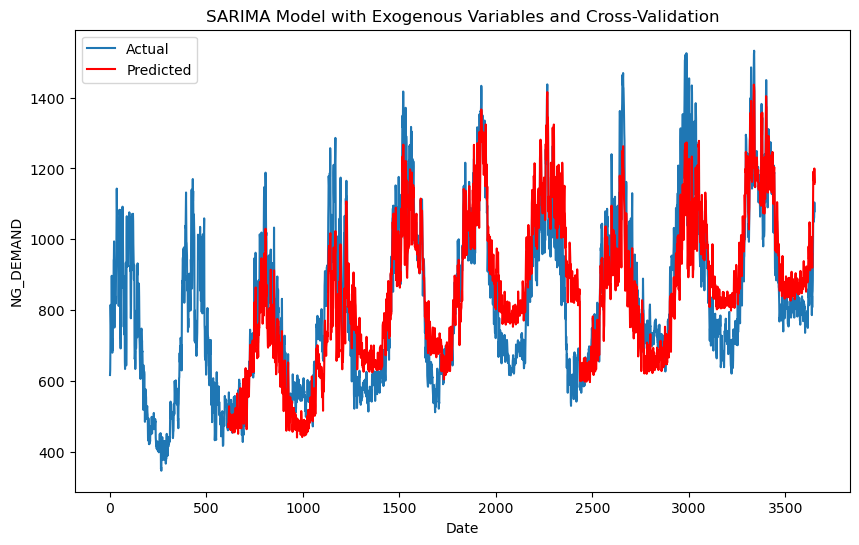

In [48]:
# Choose the target variable (NG_DEMAND in this case) and independent variables
y = merged_df['NG_DEMAND']
X = merged_df[['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
        'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
        'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']]

# Define the SARIMA model order
order = (1, 1, 1)  # (p, d, q) non-seasonal part
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, S) seasonal part

# Set up cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed

# Lists to store the actual and predicted values
actual_values = []
predicted_values = []

# Perform cross-validation
for train_index, test_index in tscv.split(y):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

    # Fit SARIMA model with exogenous variables
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")  # Ignore convergence warnings
        model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=True, maxiter=1000)  # Increase max iterations

    # Forecast future values
    forecast_steps = len(test_index)
    forecast = results.get_forecast(steps=forecast_steps, exog=X_test)

    # Store actual and predicted values
    actual_values.extend(y_test)
    predicted_values.extend(forecast.predicted_mean)

# Calculate and print additional performance metrics
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values) * 100
medae = median_absolute_error(actual_values, predicted_values)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')
print(f'Mean Absolute Percentage Error: {mape:.2f}%')
print(f'Median Absolute Error: {medae:.2f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(merged_df.index, y, label='Actual')
plt.plot(y.index[-len(predicted_values):], predicted_values, color='red', label='Predicted')
plt.title('SARIMA Model with Exogenous Variables and Cross-Validation')
plt.xlabel('Date')
plt.ylabel('NG_DEMAND')
plt.legend()
plt.show()

In [50]:
from statsmodels.tsa.stattools import adfuller
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(merged_df['NG_DEMAND'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -3.650559
p-value                           0.004865
#Lags Used                       13.000000
Number of Observations Used    3638.000000
Critical Value (1%)              -3.432149
Critical Value (5%)              -2.862335
Critical Value (10%)             -2.567193
dtype: float64


C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 66.733
R-squared (R2): 0.868
Mean Squared Error (MSE): 6406.119
Mean Absolute Percentage Error (MAPE): 7.832%
Median Absolute Percentage Error (MDAPE): 6.194%


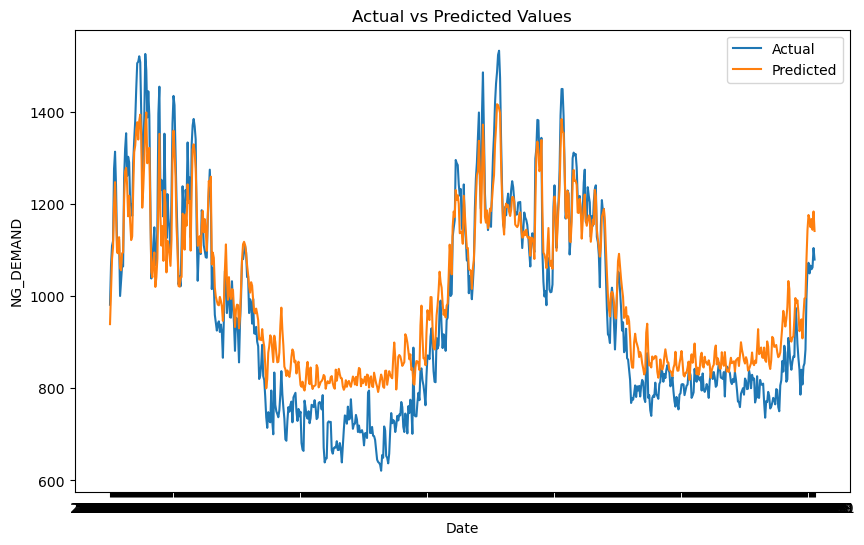

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from matplotlib import pyplot as plt

# Specify the target variable and features
target = 'NG_DEMAND'
features = merged_df.columns.drop([target, 'DATE'])

# Split the dataset into train and validation sets
train_df = merged_df[merged_df['DATE'] < '2021-12-01']
validation_df = merged_df[merged_df['DATE'] >= '2021-12-01']

# Fit the SARIMAX model
model = SARIMAX(train_df[target], exog=train_df[features], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Make predictions on the validation set
predictions = model_fit.predict(start=len(train_df), end=len(train_df)+len(validation_df)-1, exog=validation_df[features])

# Calculate the evaluation metrics
mae = mean_absolute_error(validation_df[target], predictions)
r2 = r2_score(validation_df[target], predictions)
mse = mean_squared_error(validation_df[target], predictions)
mape = np.mean(np.abs((validation_df[target] - predictions) / validation_df[target])) * 100
mdape = np.median(np.abs((validation_df[target] - predictions) / validation_df[target])) * 100

print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'R-squared (R2): {r2:.3f}')
print(f'Mean Squared Error (MSE): {mse:.3f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.3f}%')
print(f'Median Absolute Percentage Error (MDAPE): {mdape:.3f}%')

# Plot actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(validation_df['DATE'], validation_df[target], label='Actual')
plt.plot(validation_df['DATE'], predictions, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('NG_DEMAND')
plt.legend()
plt.show()

In [89]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Custom wrapper for SARIMAX to use with sklearn
class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None

    def fit(self, X, y):
        self.model = SARIMAX(y, exog=X, order=self.order, seasonal_order=self.seasonal_order)
        self.results = self.model.fit(disp=True, maxiter=120, warn_convergence=False)  # Set warn_convergence to False
        return self

    def predict(self, X):
        return self.results.get_forecast(steps=X.shape[0], exog=X).predicted_mean

# Choose the target variable (NG_DEMAND in this case) and independent variables
y = merged_df['NG_DEMAND']
X = merged_df[['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
        'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
        'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']]

# Set up cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed

# Define a pipeline combining feature selection and SARIMAX model
pipe = Pipeline([
    ('select_best', SelectKBest(score_func=f_regression)),
    ('sarimax', SARIMAXWrapper())
])

# Define a smaller grid of hyperparameters
param_grid = {
    'select_best__k': range(1, len(X.columns) + 1),
    'sarimax__order': [(p, d, q) for p in range(2) for d in range(2) for q in range(2)],
    'sarimax__seasonal_order': [(P, D, Q, S) for P in range(2) for D in range(2) for Q in range(2) for S in [12]]
}

# Set up a randomized search with cross-validation
grid = RandomizedSearchCV(pipe, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, n_iter=120)

# Perform cross-validation
for train_index, test_index in tscv.split(X):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

    # Fit and search for the best parameters
    grid.fit(X_train, y_train)

    # Get the best model
    model = grid.best_estimator_

    # Forecast future values
    forecast_steps = len(y_test)  # Ensure we only forecast as many steps as there are in the test set
    forecast = model.predict(X_test[:forecast_steps])  # Use only as many exogenous variables as there are steps to forecast

    # Store actual and predicted values
    actual_values.extend(y_test)
    predicted_values.extend(forecast)

# Calculate and print additional performance metrics
mae_sa = mean_absolute_error(actual_values, predicted_values)
mse_sa = mean_squared_error(actual_values, predicted_values)
rmse_sa = np.sqrt(mse)
r2_sa = r2_score(actual_values, predicted_values)
mape_sa = mean_absolute_percentage_error(actual_values, predicted_values) * 100
medape_sa = (median_absolute_error(actual_values, predicted_values) / np.median(actual_values)) * 100

print(f'Mean Absolute Error: {mae_sa:.2f}')
print(f'Mean Squared Error: {mse_sa:.2f}')
print(f'Root Mean Squared Error: {rmse_sa:.2f}')
print(f'R-squared: {r2_sa:.2f}')
print(f'Mean Absolute Percentage Error: {mape_sa:.2f}%')
print(f'Median Absolute Percentage Error: {medape_sa:.2f}%')

# Plot the results
#plt.figure(figsize=(10, 6))
#plt.plot(merged_df.index[-len(predicted_values):], y[-len(predicted_values):], label='Actual')
#plt.plot(merged_df.index[-len(predicted_values):], predicted_values, color='red', label='Predicted')
#plt.title('SARIMA Model with Exogenous Variables, Cross-Validation, and Hyperparameter Tuning')
#plt.xlabel('Date')
#plt.ylabel('NG_DEMAND')
#plt.legend()
#plt.show()


Mean Absolute Error: 65.42
Mean Squared Error: 6578.86
Root Mean Squared Error: 89.23
R-squared: 0.87
Mean Absolute Percentage Error: 8.13%
Median Absolute Percentage Error: 7.05%


## LSTM Model

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [28]:
# Define the scaler_y and mean_absolute_percentage_error functions
def scaler_y_inverse_transform(predictions, scaler_y):
    return scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()

#def mean_absolute_percentage_error(y_true, y_pred):
    #return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Choose the target variable (NG_DEMAND in this case) and independent variables
y = merged_df['NG_DEMAND']
X = merged_df[['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
               'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
               'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']]

# Define the pipeline
def create_pipeline():
    # LSTM model
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),  # Use MinMaxScaler outside of ColumnTransformer
        ('model', model)
    ])

    return pipeline

# Set up cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed

# Lists to store the actual and predicted values
actual_values = []
predicted_values = []

# Perform cross-validation
for train_index, test_index in tscv.split(y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Reshape the data for LSTM input
    X_train_reshaped = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

    # Build and fit the pipeline
    pipeline = create_pipeline()
    pipeline.fit(X_train, y_train, model__epochs=50, model__batch_size=32, model__verbose=0)
    
    # Assume y_train is your training target data
    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1))

    # Now you can use scaler_y to inverse transform your predictions
    predictions = pipeline.predict(X_test)
    predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()

    # Inverse transform the actual values to the original scale
    actual_values.extend(y_test)
    
    # Store predicted values
    predicted_values.extend(predictions)
    
# Calculate and print Mean Squared Error (MSE)
mse_ls = mean_squared_error(actual_values, predicted_values)
rmse_ls = np.sqrt(mse_ls)
r2_ls = r2_score(actual_values, predicted_values)
#mape_ls = mean_absolute_percentage_error(actual_values, predicted_values)

print(f'Mean Squared Error: {mse_ls:.2f}')
print(f'Root Mean Squared Error: {rmse_ls:.2f}')
print(f'R-squared: {r2_ls:.2f}')
#print(f'Mean Absolute Percentage Error: {mape_ls:.2f}%')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df.index[-len(actual_values):], actual_values, label='Actual')
plt.plot(df.index[-len(predicted_values):], predicted_values, color='red', label='Predicted')
plt.title('LSTM Model with Exogenous Variables and Cross-Validation')
plt.xlabel('Date')
plt.ylabel('NG_DEMAND')
plt.legend()
plt.show()


19/19 [==============================] - 1s 5ms/step
Mean Squared Error: 693177753022.13
Root Mean Squared Error: 832572.97
R-squared: -13748258.39


NameError: name 'df' is not defined

<Figure size 1000x600 with 0 Axes>

In [66]:
print(merged_df.columns)


Index(['DATE', 'NG_DEMAND', 'LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY',
       'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION',
       'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE',
       'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST'],
      dtype='object')


In [69]:
sarimax_df = merged_df.copy()

In [70]:
from pmdarima import auto_arima

sarimax_df['DATE'] = pd.to_datetime(sarimax_df['DATE'])
sarimax_df.set_index('DATE', inplace=True)

# Adding exogenous variable
sarimax_df['DAY_INDEX'] = sarimax_df.index.day

# Define the exogenous variables
exog_vars = ['DAY_INDEX', 'LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
             'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
             'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']

# SARIMAX Model
SARIMAX_model = auto_arima(sarimax_df['NG_DEMAND'], exogenous=sarimax_df[exog_vars],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3652
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood              -19817.342
Date:                            Sun, 10 Dec 2023   AIC                          39646.684
Time:                                    14:23:38   BIC                          39683.882
Sample:                                11-01-2013   HQIC                         39659.933
                                     - 10-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0443      0.013     83.299      0.000       1.020       1.069
ar.L2         -0.2953      0.017    -17.087      0.000      -0.329      -0.261
ar.L3          0.1569      0.013     12.436      0.000       0.132       0.182
ar.S.L12      -0.6781      0.013    -53.647      0.000      -0.703      -0.653
ar.S.L24      -0.3270      0.013    -25.694      0.000      -0.352      -0.302
sigma2      3130.2752     48.502     64.540      0.000    3035.214    3225.337
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1217.33
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.00
Prob(H) (two-sided):                  0.84   Kurtosis:                         5.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""